In [10]:
%matplotlib inline 

In [15]:
from random import randint

import numpy as np
from matplotlib import pyplot as plt

from load_data import get_training_data, get_test_data

In [16]:
training_data = get_training_data()
test_data = get_test_data()

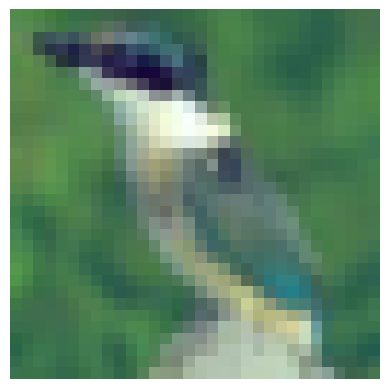

In [70]:
random_index = randint(0, len(training_data["data"]) - 1)
img = training_data["data"][random_index]

# Separate the color channels
red = img[0:1024].reshape((32, 32))
green = img[1024:2048].reshape((32, 32))
blue = img[2048:3072].reshape((32, 32))

# Stack channels along the third dimension
img_rgb = np.stack((red, green, blue), axis=2)

# Display the image
plt.imshow(img_rgb)
plt.axis('off')
plt.show()